In [78]:
from math import log
from matplotlib import pyplot as plt
from line_profiler import LineProfiler

In [79]:
%load_ext line_profiler

## Naive initial implementation

Source:  
https://stackoverflow.com/questions/1686004/fastest-way-to-convert-binary-to-decimal

We're interested in a pattern in the digits of the base 10 representation of numbers of the form $N = 2^i$  
To calculate these digits from a binary (base 2) number, we can alternate between calculating the last digit by taking the number modulo 10, and moving the next highest digit into the lowest place by doing an integer divide by 10.

In [62]:
def CalculateDigits(Number):
    Digits = []
    while Number > 0:
        Digit  = Number % 10
        Number = Number // 10
        Digits.append(Digit)
    return Digits
CalculateDigits(1<<8), 1<<8

([6, 5, 2], 256)

We can now iterate over the digits and check for our pattern.

Alternatively, we can use a built-in python function, which is way faster than doing this manualy.

In [30]:
Goliath = '666'*666

In [37]:
Number = 1<<10_000_000

In [38]:
%%timeit
Goliath in str(Number)

2min 10s ± 1.72 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sadly, this still scales very badly. for every 10x in the number, the required time goes up by 100x.  
We probably wont get rid of exponential scaling, but we can definitely reduce the constant factor.

In [74]:
Steps   = [10_000, 100_000, 1_000_000, 10_000_000]
NaiveMs = [ 0.133,    12.9,      1290,     130000]

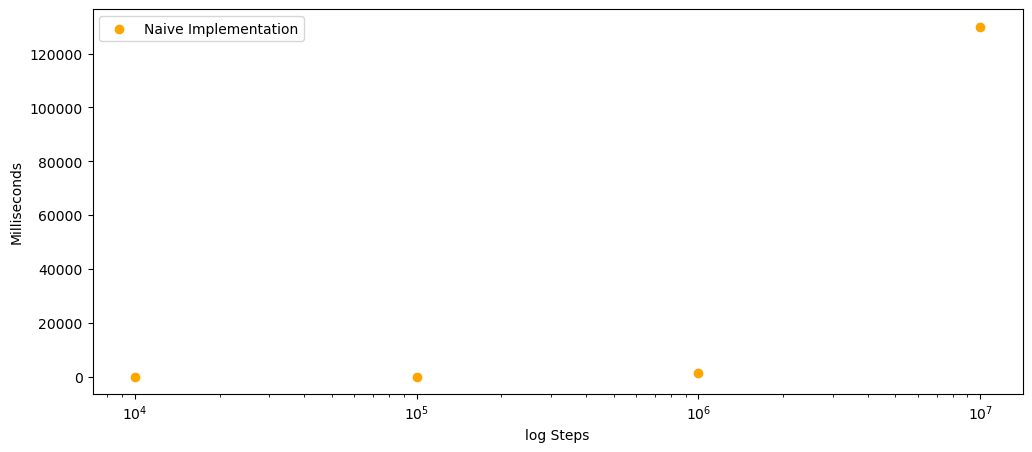

In [76]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 5))

ax.scatter(Steps, NaiveMs, label='Naive Implementation', color='orange')
ax.set_xscale('log')
ax.set_xlabel('log Steps')
ax.set_ylabel('Milliseconds')
ax.legend()
plt.show()

## Check every n'th digit

The pattern we're looking for is 666 repetitions of the digits 666 in a row. That is 1998 sixes back to back.  
Because this is a pretty long pattern, and it's the same everywhere, we can just check every n'th digits to collect evidence for the pattern, and reject the possibility of the pattern being present any time we don't see a six.  
If we assume that the base 10 expansion of powers of two have an even distribution of digits 0-9, then just a few checks will already make it massively unlikely to find a "candidate".  
Let's check for convenient divisors, and make the length of pattern we want to verify a little smaller than the actual pattern so we don't land exactly on the edge.

In [50]:
len('666' * 666)

1998

In [51]:
[(x, 1995 / x) for x in range(1, 10)]

[(1, 1995.0),
 (2, 997.5),
 (3, 665.0),
 (4, 498.75),
 (5, 399.0),
 (6, 332.5),
 (7, 285.0),
 (8, 249.375),
 (9, 221.66666666666666)]

3, 5 and 7 look like good candidates for number of checks, but the chance of getting three sixes in a row is actually a bit high, and checking 7 times means more computation, so we'll pick 5 checks per pattern length.  
This means that if we see five sixed in a row, each 399 digits apart, then our pattern could be present in that range, and we need to do a more thorough check.  
Any time we see any other digit, we know for sure that our pattern can't be in that range.

In [166]:
def count_sixes(number, divisor):
    six_counter     = 0
    six_counter_max = 0
    while number > 0:
        digit    = number % 10
        number //= divisor
        if digit == 6:
            six_counter    += 1
            six_counter_max = max(six_counter_max, six_counter)
        else:
            six_counter = 0
    return six_counter_max

In [57]:
Goliath            = '666'*666
GoliathAmount      = len(Goliath)
FatDivisor         = 10**399
CandidateThreshold = 5
Number             = 1<<8

In [58]:
Sixes = count_sixes(Number, FatDivisor)
if Sixes >= CandidateThreshold:
    print('Found a candidate!')
    if Goliath in str(Number):
        print(f'Found a goliath number!')
    else:
        print('The expensive check shows this isn\'t a goliath number after all.')
else:
    print('Not enough consecutive sixes.')

Not enough consecutive sixes.


In [65]:
Number = 1<<10_000_000

In [66]:
%%timeit
Sixes = count_sixes(Number, FatDivisor)

1min 28s ± 683 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This massively reduces the amount of work we need to do (theoretically about 400x compared to the naive version, though the divisor is now much larger), but means we're now in python land, so we don't get such a big speedup in practice.  
Still, the naive implementation has a 100x increase in the runtime for a 10x in increase in the number,  
we now only have a 10x increase in the runtime for the same increase in the number, which is already a huge win.

In [68]:
Steps        = [10_000, 100_000, 1_000_000, 10_000_000]
SkipDigitsMs = [ 0.077,    8.39,       845,      88000]

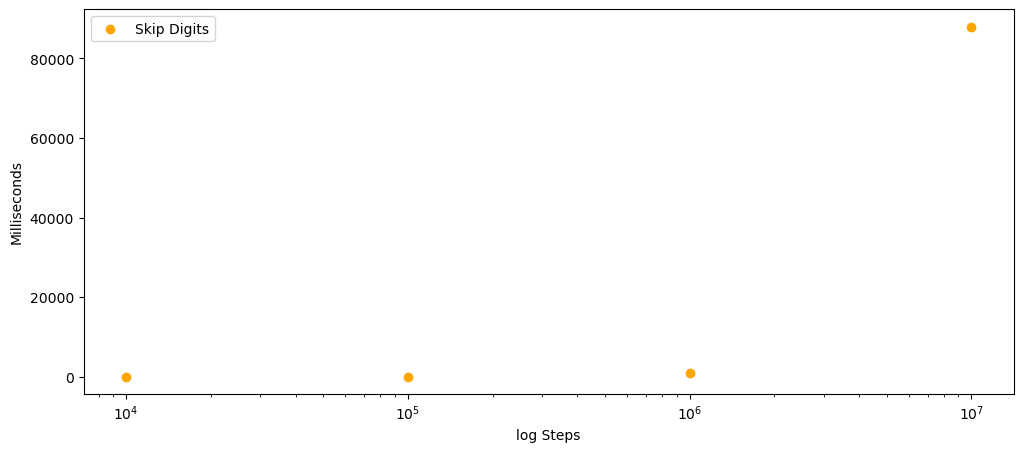

In [77]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 5))

ax.scatter(Steps, SkipDigitsMs, label='Skip Digits', color='orange')
ax.set_xscale('log')
ax.set_xlabel('log Steps')
ax.set_ylabel('Milliseconds')
ax.legend()
plt.show()

## Software Division - Continued Division

A profiler will show that we're spending the vast majority (about 95%) of the time doing the division operation.  
In order to get an idea about how to optimize this, we'll look at how binary division works when done in software.

Source:  
http://bearcave.com/software/divide.htm  
[Binary long division youtube video](https://www.youtube.com/watch?v=VKemv9u40gc)

(Quote from Ian Kaplan)  
Division is the process of repeated subtraction. Like the long division we learned in grade school, a binary division algorithm works from the high order digits to the low order digits and generates a quotient (division result) with each step. The division algorithm is divided into two steps:  
1. Shift the upper bits of the dividend (numerator) (the number we are dividing into) into the remainder.
2. Subtract the divisor from the value in the remainder. The high order bit of the result become a bit of the quotient (division result).  

/*
   Copyright stuff

   Use of this program, for any purpose, is granted the author,
   Ian Kaplan, as long as this copyright notice is included in
   the source code or any source code derived from this program.
   The user assumes all responsibility for using this code.

   Ian Kaplan, October 1996
*/

In [95]:
def unsigned_divide(numerator: 'uint', divisor: 'uint') -> ('uint', 'uint'):
    t = q = restore = bit = None # uint
    remainder = quotient = 0 # uint
    if   (divisor == 0        ): pass
    elif (divisor  > numerator): remainder = numerator
    elif (divisor == numerator): quotient  = 1
    else:
        num_bits:'uint' = 32
        while (remainder < divisor):
            bit       = (numerator & 0x80000000) >> 31 # grab the 32th bit in numerator
            remainder = (remainder << 1) | bit         # shift up remained and move bit into lowest position
            restore   = numerator                      # store for later
            numerator = (numerator << 1) & 0xFFFFFFFF  # shift up numerator, putting the next highest bit in 32th position *1
            num_bits -= 1                              # count down the number of bits remaining in numerator
        # The loop, above, always goes one iteration too far.
        # To avoid inserting an "if" statement inside the loop, the last iteration is simply reversed.
        numerator = restore        # restore numerator to previous value
        remainder = remainder >> 1 # shift remainder back down, erasing the previously lowest bit
        num_bits += 1              # undo the last counter update
        for i in range(num_bits):
            bit       = (numerator & 0x80000000) >> 31
            remainder = (remainder << 1) | bit
            t         = remainder - divisor
            q         = not ((t & 0x80000000) >> 31)
            numerator = numerator << 1
            quotient  = (quotient << 1) | q
            if (q): remainder = t
    return quotient, remainder

#### Signed divide (this doesn't interest us)

In [96]:
def signed_divide(dividend: 'int', divisor: 'int') -> ('int', 'int'):
    dend: 'uint' = abs(dividend)
    dor : 'uint' = abs(divisor)
    q   : 'uint' = None
    r   : 'uint' = None
    remainder : 'int' = 0
    quotient  : 'int' = 0
    q, r = unsigned_divide(dend, dor)
    # The sign of the remainder is the same as the sign of the dividend
    # and the quotient is negated if the signs of the operands are opposite
    quotient = q
    if (dividend < 0):
        remainder = -r;
        if (divisor > 0):
            quotient = -q;
    else: # /* positive dividend */
        remainder = r;
        if (divisor < 0):
            quotient = -q;
    return quotient, remainder
signed_divide(-4, 2)

(-2, 0)

#### We care about the last part of the unsigned division algorithm

The first part is just wrangling some bit representations around. It's not relevant to our understanding of how to optimize the division instruction.

In [105]:
def FirstPart(numerator: 'uint', divisor: 'uint', LastPart:'function') -> ('uint', 'uint'):
    remainder: 'uint' = 0
    quotient : 'uint' = 0
    if   (divisor == 0        ): raise ZeroDivisionError
    elif (divisor  > numerator): remainder = numerator
    elif (divisor == numerator): quotient  = 1
    else:
        num_bits:'uint' = 32
        while (remainder < divisor):
            bit       = (numerator & 0x80000000) >> 31
            remainder = (remainder << 1) | bit
            restore   = numerator
            numerator = (numerator << 1) & 0xFFFFFFFF
            num_bits -= 1
        numerator = restore
        remainder = remainder >> 1
        num_bits += 1
        # print(bin(numerator), bin(divisor), bin(remainder))
        quotient, remainder = LastPart(num_bits, numerator, divisor, remainder)
    return quotient, remainder

Here are a few variants of the last part which all do exactly the same thing, but are programmed slightly different

In [110]:
def LastPartV1(num_bits, numerator, divisor, remainder):
    quotient = 0
    for i in range(num_bits):
        bit       = (numerator & 0x80000000) >> 31
        remainder = (remainder << 1) | bit
        t         = remainder - divisor
        q         = not ((t & 0x80000000) >> 31)
        numerator = numerator << 1
        quotient  = (quotient << 1) | q
        if (q): remainder = t
    return quotient, remainder

In [111]:
def LastPartV2(num_bits, numerator, divisor, remainder):
    quotient = 0
    for i in range(num_bits):
        bit       = (numerator & 0x80000000) >> 31 # see above
        numerator = (numerator << 1) & 0xFFFFFFFF  # see above *1
        remainder = (remainder << 1) | bit         # see above
        t         = remainder - divisor            # remainder is larger than divisor, so get positive difference
        q         = t >= 0                         # check if result of subtraction has gone below zero *2
        quotient  = (quotient << 1) | q            # shift up quotient and store negated highest bit of previous division
        # print(i, bin(remainder),'-', bin(divisor),'=', t, f'({bin(t)})', q)
        # print(bin(numerator), bin(quotient))
        if (q): remainder = t                      # if remainder >= divisor: remainder = t
    return quotient, remainder

In [112]:
def LastPartV3(num_bits, numerator, divisor, remainder):
    quotient = 0
    for i in range(num_bits):
        bit       = (numerator & 0x80000000) >> 31 # see above
        numerator = (numerator << 1) & 0xFFFFFFFF  # see above *1
        remainder = (remainder << 1) | bit         # see above
        if remainder >= divisor:                   #
            # print(i, bin(remainder),'-', bin(divisor),'=', bin(remainder - divisor))
            remainder = remainder - divisor        # 
            quotient  = (quotient << 1) | 1        # shift in a 1
        else:                                      #
            # print(i, )
            quotient  = (quotient << 1)            # shift in a zero
        # print(bin(numerator), bin(quotient))
    return quotient, remainder

In [114]:
FirstPart(150, 4, LastPartV3)

(37, 2)

In [101]:
150 // 4, 150 % 4

(37, 2)

*1 Python support arbitrary sized integers, so shifting up doesn't actually remove the highest bit, but instead just moves in a 0 at the right, effectively doubling the number. Since we're grabbing the 32th bit every time this doesn't really matter, but should we want this algorithm to work with arbitrary sized integers instead of fixed 32 bit, then this need to be changed. To "fix this we could replace `numerator << 1` with `(numerator << 1) & 0xFFFFFFFF`.

---

*2 In a C program, we would be working with unsigned numbers here, which wrap around to max int when going below zero. So when we're testing the highest bit for 0 or 1, we're really asking if we've wrapped around, or in other words, gone negative. So since we're working with signed integers in python, `not ((t & 0x80000000) >> 31)` really is equivalent to `t >= 0`, which in turn is equivalent to checking if `remainder >= divisor`.

---



#### The insight

This version is really interesting, because it shows more clearly what is going on.

In [115]:
def LastPartV3(num_bits, numerator, divisor, remainder):
    quotient = 0
    for i in range(num_bits):
        bit       = (numerator & 0x80000000) >> 31
        numerator = (numerator << 1) & 0xFFFFFFFF
        remainder = (remainder << 1) | bit
        if remainder >= divisor:
            remainder = remainder - divisor
            quotient  = (quotient << 1) | 1
        else:
            quotient  = (quotient << 1)
    return quotient, remainder

Producing the result of a binary long division is an iterative process, which processes the bits of the numerator one after the other from most to least significant bit (from left to right).  
On each iteration, the current bit is shifted into the least significant bit of the remainder.  
The remainder is then compared to the divisor, and depending on the result, a one or a zero is shifted into the quotient, while the remainder is reduced back down below the divisor by subtraction.  
__The insight__ we can use is that we only need a single (least significant) bit from the numerator for each next iteration, and in our algorithm we just so happen to shift the numerator up by one bit each time we go on to check the next power of two.  
In other words, on each iteration of our algorithm, we have a new zero in the least significant bit of the numerator. With this new least significant bit, we can do one iteration of binary long division.  
We can thus use the result of the $2^{i-1}$ long division and do a single shift-compare-update iteration, and we have the result of the $2^i$ long division.

In [1]:
def ContinueDivision(Quotient, Remainder, Divisor):
    Remainder = (Remainder << 1) # Shift in a zero, since we know that the last bit of 2^i will always be a zero.
    if Remainder >= Divisor:
        Remainder = Remainder - Divisor
        Quotient  = (Quotient << 1) | 1
    else:
        Quotient  = (Quotient << 1)
    return Quotient, Remainder

In [10]:
NumberA    = 1<<1_000_000_000
Divisor    = 10**399

QuotientA  = NumberA // Divisor
RemainderA = NumberA % Divisor

NumberB    = NumberA << 1
QuotientB  = NumberB // Divisor
RemainderB = NumberB % Divisor

In [16]:
assert ContinueDivision(QuotientA, RemainderA, Divisor) == (QuotientB, RemainderB)

In [ ]:
%%timeit
Q, R = NumberB // Divisor, NumberB % Divisor

In [ ]:
%%timeit
Q, R = ContinueDivision(QuotientA, RemainderA, Divisor)

We can see that while the two algorithms scale the same, the continued division is about 60x - 120x faster.  

In [17]:
Steps               = [10_000, 100_000, 1_000_000, 10_000_000, 100_000_000]
FullDivisionMs      = [0.057 ,   0.646,      6.27,       67.3,         664]
ContinuedDivisionMs = [0.001 ,   0.005,     0.045,       1.26,        12.3]

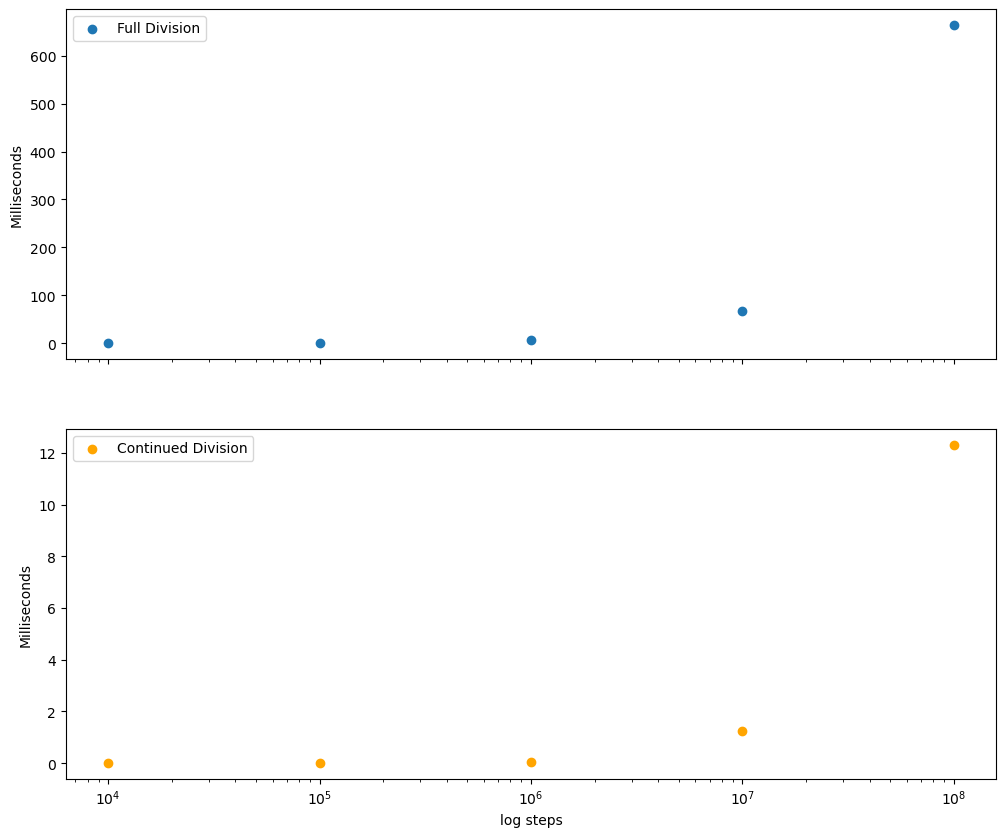

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 10))

ax1.scatter(Steps, FullDivisionMs, label='Full Division')
ax1.set_ylabel('Milliseconds')
ax1.legend()

ax2.scatter(Steps, ContinuedDivisionMs, label='Continued Division', color='orange')
ax2.set_xscale('log')
ax2.set_xlabel('log steps')
ax2.set_ylabel('Milliseconds')
ax2.legend()
plt.show()

#### Apply this to our problem in praxis

So far, we know that we could use this algorithm on the first step of our division.  
But we actually divide any $2^i$ number many times in a row in order to get its digits.  
And while we can calculate any subsequent division result $2^i_j$ by changing the divisor, that requires us to store the intermediate results, as well as the divisors for every step. It's still faster than doing the full division, but very memory intensive, and wastefull. Still let's try this first, since we already know that it will work.  

In [167]:
def count_sixes(Number, Divisors, Cache):
    SixCounter    = 0
    SixCounterMax = 0
    j = 0
    N = Number
    while N > 0:
        Digit = N % 10
        if Digit == 6:
            SixCounter   += 1
            SixCounterMax = max(SixCounterMax, SixCounter)
        else:
            SixCounter = 0
        try: # try to retrieve previous calculations from the caches.
            D    = Divisors[j]
            N, R = Cache[j]
            # This is the continued divison code from above
            R = (R << 1)
            if R >= D:
                R = R - D
                N = (N << 1) | 1
            else:
                N = (N << 1)
        except KeyError:
            # the cache misses get expensive. we need to calculate the j'th divisor,
            # as well as do a divide and a modulo on the full number. All of these numbers grow over iterations.
            D = 10**(399*(j+1))
            N = Number // D
            R = Number  % D
            Divisors[j] = D
        Cache[j] = N, R
        j += 1
    return SixCounterMax

In [179]:
%%time
i        = 1_000_000
Number   = 1<<(i - 1)
print('Building Caches...')
Divisors = {}
Cache    = {}
count_sixes(Number, Divisors, Cache)
Number = Number << 1
print('Done!')

Building Caches...
Done!
CPU times: total: 5min 32s
Wall time: 5min 33s


In [181]:
%%time
for _ in range(100):
    count_sixes(Number, Divisors, Cache)
    i      += 1
    Number  = Number<<1

CPU times: total: 6.81 s
Wall time: 6.81 s


In [22]:
# Verify cache
assert Number == 1<<i
assert len(Divisors) == len(Cache)
assert Divisors[0] == 10**399
assert (Number>>1) // Divisors[0] == Cache[0][0]
assert (Number>>1)  % Divisors[0] == Cache[0][1]
j = len(Cache) - 1
assert (Number>>1) // Divisors[j] == Cache[j][0] == 0
assert (Number>>1)  % Divisors[j] == Cache[j][1]
assert j+1 not in Cache
del j

This works, but it's painfully slow to build the cache for larger numbers. Obviously this only has to be done once, but it still means significant time is spent on cache misses.  
These are values for 100 iterations, so it's much better than previous by about a factor 10x.

In [68]:
Steps        = [10_000, 100_000, 1_000_000, 10_000_000]
BuildCacheMs = [ 0.455,   342.0,    333000,       None]
SkipDigitsMs = [ 0.997,    69.8,      6810,       None]

It would be much better if we could make every step $j$ of the process for calculating the digits a continued division.  
Turns out that works as well, and we can scrap the different divisors.  

In [182]:
def count_sixes(N, D, Cache):
    SixCounter    = 0
    SixCounterMax = 0
    j = 0
    while N > 0:
        Digit = N % 10
        if Digit == 6:
            SixCounter   += 1
            SixCounterMax = max(SixCounterMax, SixCounter)
        else:
            SixCounter = 0
        try:
            # take last bit from previous result of the current i (N), not current result of the previous i (Q),
            Q, R = Cache[j]
            R    = (R << 1) | (N & 1)
            if R >= D:
                R = R - D
                N = (Q << 1) | 1
            else:
                N = (Q << 1)
        except KeyError:
            R = N  % D
            N = N // D
        Cache[j] = N, R
        j += 1
    return SixCounterMax

In [191]:
%%time
i        = 10_000_000
Number   = 1<<(i - 1)
print('Building Cache...')
Divisor = 10**399
Cache2   = {}
count_sixes(Number, Divisor, Cache2)
Number = Number << 1
print('Done!')

Building Cache...
Done!
CPU times: total: 2min 56s
Wall time: 2min 58s


In [193]:
%%time
for _ in range(100):
    count_sixes(Number, Divisor, Cache2)
    i      += 1
    Number  = Number<<1

CPU times: total: 10min 11s
Wall time: 10min 15s


In [27]:
# Verify cache
assert Number  == 1<<i
assert Divisor == 10**399
assert (Number>>1) // Divisor == Cache2[0][0]
assert (Number>>1)  % Divisor == Cache2[0][1]
j            = len(Cache2) - 1
j0thDivision = (Number>>1) // (10**(399*(j  )))
j1thDivision = (Number>>1) // (10**(399*(j+1)))
assert j0thDivision != 0
assert j1thDivision           == Cache2[j][0] == 0
assert j0thDivision % Divisor == Cache2[j][1]
assert j+1 not in Cache
del j, j0thDivision, j1thDivision

In [201]:
(845 * 100) / 5010

16.86626746506986

And suddenly, the cache building is much faster!  

In [68]:
Steps        = [10_000, 100_000, 1_000_000, 10_000_000]
BuildCacheMs = [ 0.998,    16.0,      1700,     125800]
SkipDigitsMs = [  1.99,    54.9,      5010,     615000]

## Speed up modulo by using remainder instead of entire number

Testing if we can use the remainder of a division with a large multiple of 10 to speed up the computation of modulo 10.

In [11]:
N = 1<<1001

In [12]:
one = N % 10**1

In [13]:
two = N % 10**2

In [14]:
three = N % 10**3

In [15]:
four = N % 10**4

In [16]:
five = N % 10**5

In [17]:
six = N % 10**6

In [18]:
seven = N % 10**7

In [19]:
eight = N % 10**8

In [20]:
one, two, three, four, five, six, seven, eight

(2, 52, 752, 8752, 38752, 138752, 6138752, 36138752)

In [122]:
N

42860344287450692837937001962400072422456192468221344297750015534814042044997444899727935152627834325103786916702125873007485811427692561743938310298794299215738271099296923941684298420249484567511816728612185899934327765069595070236662175784308251658284785910746168670641719326610497547348822672277504

In [123]:
N % 10**399

42860344287450692837937001962400072422456192468221344297750015534814042044997444899727935152627834325103786916702125873007485811427692561743938310298794299215738271099296923941684298420249484567511816728612185899934327765069595070236662175784308251658284785910746168670641719326610497547348822672277504

It seems like any time we do a `n mod 10**k`, we're really grabbing about the last k decimal digits of the number n. So if we then do a mod 10 afterwards on that value, we will get the result of n mod 10, without having to do the whole computation again.  
With this realisation it's obvious that we can just take the modulo of the remainder instead of the entire number, saving massively on computation.

In [209]:
profiler = LineProfiler()
@profiler
def count_sixes(N, D, Cache):
    SixCounter    = 0
    SixCounterMax = 0
    j = 0
    while N > 0:
        # TODO: use continued division for this as well? Or can we just use the remainder instead of the number?
        Digit = N % 10
        if Digit == 6:
            SixCounter   += 1
            SixCounterMax = max(SixCounterMax, SixCounter)
        else:
            SixCounter = 0
        try:
            Q, R = Cache[j]
            R    = (R << 1) | (N & 1)
            if R >= D:
                R = R - D
                N = (Q << 1) | 1
            else:
                N = (Q << 1)
        except KeyError:
            R = N  % D
            N = N // D
        Cache[j] = N, R
        j += 1
    return SixCounterMax

In [213]:
# This is the new version
profiler = LineProfiler()
@profiler
def count_sixes(N, D, Cache):
    SixCounter    = 0
    SixCounterMax = 0
    j = 0
    while N > 0:
        try:
            Q, R = Cache[j]
            R    = (R << 1) | (N & 1)
            if R >= D:
                R = R - D
                N = (Q << 1) | 1
            else:
                N = (Q << 1)
        except KeyError:
            R = N  % D
            N = N // D
        Cache[j] = N, R
        j += 1
        
        Digit = R % 10
        if Digit == 6:
            SixCounter   += 1
            SixCounterMax = max(SixCounterMax, SixCounter)
        else:
            SixCounter = 0
        
    return SixCounterMax

In [214]:
%%time
i        = 100_000
Number   = 1<<(i - 1)
print('Building Cache...')
Divisor = 10**399
Cache   = {}
count_sixes(Number, Divisor, Cache)
Number = Number << 1
print('Done!')

Building Cache...
Done!
CPU times: total: 31.2 ms
Wall time: 18 ms


In [211]:
%%time
output = []
for _ in range(1000):
    output.append(count_sixes(Number, Divisor, Cache))
    i      += 1
    Number  = Number<<1
print(output)

[2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 6, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 1, 1, 3, 2, 1, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 3, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 4, 1, 1, 3, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 2, 

In [215]:
%%time
output = []
for _ in range(1000):
    output.append(count_sixes(Number, Divisor, Cache))
    i      += 1
    Number  = Number<<1
print(output)

[2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 6, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 1, 1, 3, 2, 1, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 3, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 4, 1, 1, 3, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 2, 

In [207]:
[2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 6, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 1, 1, 3, 2, 1, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 3, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 4, 1, 1, 3, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 3, 2, 3, 4, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 3, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 3, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 3, 2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 3, 1, 1, 2, 1, 1, 1, 2, 4, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 4, 3, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 3, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 4, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 3, 2, 3, 1, 1, 1, 1, 2, 3, 1, 3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 3, 1, 2, 2, 2, 3, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 3, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 2, 3, 1, 1, 1, 3, 3, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 2, 3, 1, 3, 1, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 3, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2] == [2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 3, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 6, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 1, 1, 3, 2, 1, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1, 3, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 4, 1, 1, 3, 1, 2, 1, 1, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 3, 2, 3, 4, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 3, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 3, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 3, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 3, 2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 3, 1, 1, 2, 1, 1, 1, 2, 4, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 1, 1, 4, 3, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 3, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 4, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 3, 2, 3, 1, 1, 1, 1, 2, 3, 1, 3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 3, 1, 2, 2, 2, 3, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 3, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 2, 3, 1, 1, 1, 3, 3, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 2, 3, 1, 3, 1, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 3, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2]

True

In [212]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 0.7823 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_16104\356962432.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache):
     4      1001       2489.0      2.5      0.0      SixCounter    = 0
     5      1001       2437.0      2.4      0.0      SixCounterMax = 0
     6      1001       2445.0      2.4      0.0      j = 0
     7     77342     190859.0      2.5      2.4      while N > 0:
     8                                                   # TODO: use continued division for this as well? Or can we just use the remainder instead of the number?
     9     76341    4213638.0     55.2     53.9          Digit = N % 10
    10     76341     188286.0      2.5      2.4          if Digit == 6:
    11      7925      21975.0      2.8      0.3              SixCounter   += 1
 

In [216]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 0.388465 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_16104\3149308276.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache):
     4      1001       2521.0      2.5      0.1      SixCounter    = 0
     5      1001       2312.0      2.3      0.1      SixCounterMax = 0
     6      1001       2215.0      2.2      0.1      j = 0
     7     77342     194824.0      2.5      5.0      while N > 0:
     8     76341     157660.0      2.1      4.1          try:
     9     76341     265909.0      3.5      6.8              Q, R = Cache[j]
    10     76264     315681.0      4.1      8.1              R    = (R << 1) | (N & 1)
    11     76264     196525.0      2.6      5.1              if R >= D:
    12     37555     124209.0      3.3      3.2                  R = R - D
    13    

## Improve Candidate selection

So far we're checking every 399th digit of the number for a six, and if we find five such sixes in a row anywhere in the number, we declare the number a candidate for more thorough checking. This works very good and has given us a massive speedup already. However since the numbers are growing bigger and bigger, the chance of finding a candidate in this way also go up. At the start the probability was about 0.3%, but now it's become over 2%. This is not ideal since the thorough check is very expensive, and we want to do as little of them as possible.  
To reduce the likelyhood of detecting a candidate, we can simply check more digits. The more digits we check, the slower we progress however.  
What we've done here is to check more digits, but only if we've already detected 5 sixes in the usual way. On the fast pass this is only a single if statement more whenever we hit a six, and on the slow pass, we now just start checking k digits between the 4th and 5th segment where we have already found the sixes at the start and end. All of these digits need to be sixes in order to be a goliath number, so a single non six immediately stops our search, and we continue with taking large strides through the digits of the number.

In [149]:
def count_sixes_old(N, D, Cache):
    SixCounter    = 0
    SixCounterMax = 0
    j = 0
    while N > 0:
        try:
            Q, R = Cache[j]
            R    = (R << 1) | (N & 1)
            if R >= D:
                R = R - D
                N = (Q << 1) | 1
            else:
                N = (Q << 1)
        except KeyError:
            R = N  % D
            N = N // D
        Cache[j] = N, R
        j += 1
        
        Digit = R % 10
        if Digit == 6:
            SixCounter   += 1
            SixCounterMax = max(SixCounterMax, SixCounter)
        else:
            SixCounter = 0
        
    return SixCounterMax

In [151]:
profiler = LineProfiler()
@profiler
def count_sixes(N, D, Cache, k=1):
    SixCounter    = 0
    SixCounterMax = 0
    j = 0
    while N > 0:
        try:
            Q, R = Cache[j]
            R    = (R << 1) | (N & 1)
            if R >= D:
                R = R - D
                N = (Q << 1) | 1
            else:
                N = (Q << 1)
        except KeyError:
            R = N  % D
            N = N // D
        Cache[j] = N, R
        
        Digit = R % 10
        if Digit == 6:
            SixCounter += 1
            if SixCounter == 5:
                # Go back and run a more expensive check to reduce likelyhood of selecting (wrong) candidates.
                # If this is a goliath number, then this needs to now be all sixes.
                R = (Cache[j-1][1]) // 10 # We already know the last digit is a six, so skip it.
                for _ in range(k):
                    Digit = R % 10
                    if Digit == 6:
                        R = R // 10
                    else:
                        SixCounter = 1 # Set to one because the digit here at j is actually a 6.
                        break
            SixCounterMax = max(SixCounterMax, SixCounter) # This is not in the else block to support k = 0
        else:
            SixCounter = 0
        j += 1
    return SixCounterMax

In [54]:
%%time
i        = 100_000
Divisor = 10**399

Building Cache...
1
Done!
CPU times: total: 15.6 ms
Wall time: 17.1 ms


In [66]:
G = int('666'*666)

In [153]:
%%time
i      = 1_400_052
Number = 1<<(i)
count_sixes(Number, Divisor, {}, k=2)

CPU times: total: 3.3 s
Wall time: 3.3 s


4

In [154]:
count_sixes_old(Number, Divisor, {})

5

## Only store the last bit of each number, and the remainder?

Currently, for each step we take through the 399 size chunks of the number, we're storing the entire number left at that point, as well as the remainder. This is already a red flag, since if our cache is p segments long, that means that the very last segment (the very beginning of the number) is stored p times. The p-1 th segment is stored p-1 times and so on, essentially creating a huge triangle if we were to visualise the data.  
When we look at the algorithm, we really only need the remainder and the last bit of the previous number. Even when we miss the cache, we have a pretty good idea of what the next number should be. Do some more testing, but a new segment added to the cache should always be a zero at first, and some remainder. 

In [423]:
def count_sixes_old(N, D, Cache, k=1):
    SixCounter    = 0
    SixCounterMax = 0
    j = 0
    while N > 0:
        try:
            Q, R = Cache[j]
            R    = (R << 1) | (N & 1)
            if R >= D:
                R = R - D
                N = (Q << 1) | 1
            else:
                N = (Q << 1)
        except KeyError:
            R = N  % D
            N = N // D
        Cache[j] = N, R
        
        Digit = R % 10
        if Digit == 6:
            SixCounter += 1
            if SixCounter == 5:
                R = (Cache[j-1][1]) // 10
                for _ in range(k):
                    Digit = R % 10
                    if Digit == 6:
                        R = R // 10
                    else:
                        SixCounter = 1
                        break
            SixCounterMax = max(SixCounterMax, SixCounter)
        else:
            SixCounter = 0
        j += 1
    return SixCounterMax

In [424]:
def RebuildCacheOld(LastNumber):
    """If the cache gets corrupted, use this to rebuild it.
    Be warned, this can take multiple seconds!"""
    Cache = {}
    i      = LastNumber
    Number = 1<<(i - 1)
    N = Number
    D = 10**399
    j = 0
    while N > 0:
        R = N  % D
        N = N // D
        Cache[j] = N, R
        j += 1
    return i, (Number<<1), D, Cache

In [425]:
def VerifyCacheOld(i, Number, Divisor, Cache):
    'If all of these checks pass, then it should be fine to use these values to continue the search.'
    assert Number  == 1<<i
    assert Divisor == 10**399
    assert (Number>>1) // Divisor == Cache[0][0]
    assert (Number>>1)  % Divisor == Cache[0][1]
    j            = len(Cache) - 1
    j0thDivision = (Number>>1) // (10**(399*(j  )))
    j1thDivision = (Number>>1) // (10**(399*(j+1)))
    assert j0thDivision != 0
    assert j0thDivision           == Cache[j-1][0]
    assert j1thDivision           == Cache[j][0] == 0
    assert j0thDivision % Divisor == Cache[j][1]
    assert j+1 not in Cache

In [428]:
def RebuildCache(LastNumber):
    """If the cache gets corrupted, use this to rebuild it.
    Be warned, this can take multiple seconds!"""
    i = LastNumber
    N = 1<<(i - 1)
    D = 10**399
    Cache = []
    while N > 0:
        R = N  % D
        N = N // D
        Cache.append(R)
    return i, D, Cache

In [429]:
def VerifyCache(i, Divisor, Cache):
    'If all of these checks pass, then it should be fine to use these values to continue the search.'
    Number = 1<<(i - 1)
    assert Divisor == 10**399
    assert Number % Divisor == Cache[0]
    j            = len(Cache) - 1
    j0thDivision = Number // (10**(399*(j  )))
    j1thDivision = Number // (10**(399*(j+1)))
    assert j0thDivision != 0
    assert j1thDivision == 0
    assert j0thDivision % Divisor == Cache[j]
    assert Cache[-1] != 0

We iterate until N is no longer larger than 0, which means that at the last step, N will have to have been 0 for the loop to end.  
Let's say it is, then it can either be already in the cache, or it can be missing from the cache. In the case where we have a cache hit, we will increase R as usual and then check if it's become larger than D or not. If it hasn't, then N doesn't change. Shifting a zero to the left doesn't change the number, so it's still a zero, and the loop ends.  
If R has become larger than D, then we decrease R again, again shift the zero to the left, but now also "and" it with one. This means N is now 1, which means that the loop will continue.  
We will now enter the case where we have a cache miss.  
The new N and R are calculated by dividing the previous N, and taking the modulo of N respectively, each with the given Divisor. But we already know that the previous N must be a 1. Since D is larger than one, a floor division between 1 and D will always give 0 as the answer. Similarly, 1 mod D will always give 1 as the answer.  
This means the new N will be 0, and the new R will be 1, no matter what happened in the iteration before.

In [437]:
# profiler = LineProfiler()
# @profiler
def count_sixes(D, Cache, k=1):
    SixCounter    = 0
    SixCounterMax = 0
    N = 0
    J = len(Cache)
    for j in range(J):
        R = (Cache[j] << 1) | N
        if R >= D:
            R = R - D
            N = 1
        else:
            N = 0
        Cache[j] = R
        
        Digit = R % 10
        if Digit == 6:
            SixCounter += 1
            if SixCounter == 5:
                R = (Cache[j-1]) // 10
                for _ in range(k):
                    Digit = R % 10
                    if Digit == 6:
                        R = R // 10
                    else:
                        SixCounter = 1
                        break
            SixCounterMax = max(SixCounterMax, SixCounter)
        else:
            SixCounter = 0
    if N > 0:
        # print('hi')
        # Cache[J] = 1
        Cache.append(1)
    return SixCounterMax

In [447]:
%%time
i, Number, Divisor, Cache = RebuildCacheOld(1_000_000)
VerifyCacheOld(i, Number, Divisor, Cache)

CPU times: total: 1.64 s
Wall time: 1.64 s


In [448]:
%%time
output = []
for _ in range(1000):
    output.append(count_sixes_old(Number, Divisor, Cache))
    i      += 1
    Number  = Number<<1

CPU times: total: 9.94 s
Wall time: 9.96 s


In [ ]:
# New

In [449]:
%%time
i, Divisor, Cache = RebuildCache(1_000_000)
VerifyCache(i, Divisor, Cache)

CPU times: total: 1.62 s
Wall time: 1.64 s


In [450]:
%%time
output2 = []
for _ in range(1_000):
    output2.append(count_sixes(Divisor, Cache))
    i      += 1

CPU times: total: 297 ms
Wall time: 305 ms


In [451]:
output == output2

True

In [455]:
VerifyCache(i, Divisor, Cache)

Crushing defeat!!!  

The new version is at least 5x faster than the old one.

In [418]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 7.88987 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_20112\3990742229.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(D, Cache, k=1):
     4      1000       4742.0      4.7      0.0      SixCounter    = 0
     5      1000       3561.0      3.6      0.0      SixCounterMax = 0
     6      1000       2571.0      2.6      0.0      N = 0
     7      1000       8541.0      8.5      0.0      J = len(Cache)
     8   3019792    7982991.0      2.6     10.1      for j in range(J):
     9   3018792   12152451.0      4.0     15.4          R = (Cache[j] << 1) | N
    10   3018792    7493703.0      2.5      9.5          if R >= D:
    11   1508042    4779038.0      3.2      6.1              R = R - D
    12   1508042    3723418.0      2.5      4.7              N = 1
    13               

## Which python loop is fastest

In [4]:
Cache = [10**399] * 4000

In [14]:
%%timeit
J = len(Cache)
for j in range(J):
    R = Cache[j]
    # Do stuff with R
    Cache[j] = R

217 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
%%timeit
for j in range(len(Cache)):
    R = Cache[j]
    # Do stuff with R
    Cache[j] = R

216 µs ± 913 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%%timeit
for (j, R) in enumerate(Cache):
    # Do stuff with R
    Cache[j] = R

181 µs ± 646 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Future Opmizitations

## Replace the divide instruction by multiply and shift, or adds and shifts

Source:  
https://en.m.wikipedia.org/wiki/Division_algorithm#Division_by_a_constant    
https://stackoverflow.com/questions/5558492/divide-by-10-using-bit-shifts  
OEIS

The OEIS sequences [A346495](https://oeis.org/A346495) and [A346496](https://oeis.org/A346496) are used for replacing division with multiplication via an approximation of the inverse of the divisor, if the computer supports multiplying two 32-bit numbers for a 64-bit result.  
This is usually much faster than a division instruction because integer division is a very slow operation on most computers.

Smallest a(n) so that division by n can be performed by $$\left\lfloor\frac{x}{n}\right\rfloor = \frac{\lfloor(x*a(n)\rfloor}{2^{b(n)}}$$ for all $0 <= x < 2^{32}$. 

In [1]:
def power_of_two(n):
    return n == (1<<(n.bit_length()-1))

In [2]:
def a(n):
    Result = 1
    if not power_of_two(n):
        n_c = ((1<<32) - ((1<<32) % n)) - 1
        b   = 1
        while (1<<b) <= (n_c * ((n - 1) - (((1<<b) - 1) % n))):
            b += 1
        Result = ((1<<b) + (n - 1) - (((1<<b) - 1) % n)) // n
    return Result

In [4]:
def b(n):
    Result = None
    if power_of_two(n):
        Result = n.bit_length() - 1
    else:
        n_c = ((1<<32) - ((1<<32) % n)) - 1
        b   = 1
        while (1<<b) <= (n_c * ((n - 1) - (((1<<b) - 1) % n))):
            b += 1
        Result = b
    return Result

In [3]:
print([a(n) for n in range(1, 26)])

[1, 1, 2863311531, 1, 3435973837, 2863311531, 4908534053, 1, 954437177, 3435973837, 3123612579, 2863311531, 1321528399, 4908534053, 2290649225, 1, 4042322161, 954437177, 7233629131, 3435973837, 6544712071, 3123612579, 2987803337, 2863311531, 1374389535]


In [15]:
print([b(n) for n in range(1, 26)])

[0, 1, 33, 2, 34, 34, 35, 3, 33, 35, 35, 35, 34, 36, 35, 4, 36, 34, 37, 36, 37, 36, 36, 36, 35]


Here we compute both a and b at the same time.

In [20]:
LIMIT     = 32
BIT_LIMIT = 1<<LIMIT
def seq(n):
    A = 1
    B = n.bit_length() - 1
    j = n - 1
    if not (n == (1<<B)):
        k = (BIT_LIMIT - (BIT_LIMIT % n)) - 1
        B   = 1
        B2  = 1<<B
        while B2 <= (k * (j - ((B2 - 1) % n))):
            B += 1
            B2 = B2<<1
        A = (B2 + j - ((B2 - 1) % n)) // n
    return (A, B)

In [19]:
print([seq(n) for n in range(1, 26)])

[(1, 0), (1, 1), (2863311531, 33), (1, 2), (3435973837, 34), (2863311531, 34), (4908534053, 35), (1, 3), (954437177, 33), (3435973837, 35), (3123612579, 35), (2863311531, 35), (1321528399, 34), (4908534053, 36), (2290649225, 35), (1, 4), (4042322161, 36), (954437177, 34), (7233629131, 37), (3435973837, 36), (6544712071, 37), (3123612579, 36), (2987803337, 36), (2863311531, 36), (1374389535, 35)]


For our usecase, we would like to operate on numbers much larger than 32 or even 64 bits.  
Luckily there is another way to compute these "magic numbers".

Source:  
Hacker's delight page 218 (chapter 10–15 Simple Code in Python)

In [23]:
def magicgu_slow(nmax, d):
    dminus1      = d - 1
    nc           = (nmax // d) * dminus1
    search_range = 1 + (2 * nmax.bit_length())
    for p in range(0, search_range):
        q         = 1<<p
        qminus1   = q - 1
        remainder = (qminus1 % d)
        if q > (nc * (dminus1 - remainder)):
            m = ((q + dminus1) - remainder) // d
            return (m, p)
    raise Exception('Couldn\'t find a solution, something is wrong.')

Optimization:  
Switching from a linear search to a binary search reduces the runtime for inputs `m, p = magicgu(1<<1_000_000, 10**399)` from 40 minutes to 0.08 seconds, taking just 24 iterations to converge on the correct value.

In [24]:
def magicgu(nmax, d):
    """
    Given the maximum value of the dividend nmax and the divisor d, returns a pair of integers:
        the magic number m and a shift amount p.
    To divide a dividend x by d, one multiplies x by m and then shifts the (full length) product right p bits.
    This works because m / p will be very close to 1 / d, and p will be a power of two, making the divide a simple bit shift.
    """
    dminus1 = d - 1
    nc      = (nmax // d) * dminus1
    lowest  = 0
    highest = 1 + (2 * nmax.bit_length())
    while lowest < highest:
        p         = (highest + lowest) // 2
        q         = 1<<p
        qminus1   = q - 1
        remainder = (qminus1 % d)
        if q > (nc * (dminus1 - remainder)):
            highest = p
        else:
            lowest  = p + 1
    p         = (highest + lowest) // 2
    q         = 1<<p
    qminus1   = q - 1
    remainder = (qminus1 % d)
    m         = ((q + dminus1) - remainder) // d
    return (m, p)

Example 1

In [42]:
nmax = 1<<1_000_000
d    = 10**399

In [44]:
m, p = magicgu(nmax, d)

In [45]:
x = 1<<999_900

In [46]:
assert x < nmax

In [47]:
%%timeit
(x * m) >> p

4.37 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
%%timeit
x // d

3.02 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Example 2

In [36]:
nmax = 10**399
d    = 10

In [37]:
m, p = magicgu(nmax, d); m, p

(292957247209924852137075224890370171032692958681326960826984919130001827539839214697757948051204538105646676347303848625162902618953473698102408269423433879425259310757283275210972425883538122452847336119254634643499505917091533837488298906776482947295647220679792987618467923311462718229513113755678107850012507556042175979861246759917806100226846569645613245309343003296469005736181778637822676173,
 1327)

In [38]:
# An example number we've come across in the algorithm we're trying to optimize.
x = 675498068352129731964884062763533329144415921218630285019127698639680940044270154133162810213979906631608629547659877222303938885553947675194806514177810321278967470122934933377995913130368225534489724572693654861728928532250033597205506631158056720564410536312378792296760105033917922985829102352323964365789020903947560236392997251191841134769795404868939332473278193403660671793915429281166670196

In [39]:
assert x < nmax

In [40]:
%%timeit
(x * m) >> p

3.32 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [41]:
%%timeit
x // 10

268 ns ± 11.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


This works, but sadly it's not really faster than the usual division, even when the number we're dividing is close to the maximum (which makes the difference between the mult and shift version and the division version the smallest).

If the divisor and the maximum size are fixed (which they are in our case), we can go another approach which even gets rid of the multiply instruction and instead does a bunch of adds and shifts.  
Sadly this implementation again only works for 32 bit integers

Source:  
Hackers Delight (see above)

In [50]:
def divu10(n):
    q  = (n >> 1) + (n >> 2)
    q += (q >> 4)
    q += (q >> 8)
    q += (q >> 16)
    q  = (q >> 3)
    r  = n - (((q << 2) + q) << 1)
    return q + (r > 9), r
divu10(21)

(2, 11)

In [51]:
def divu100(n):
    q = (n >> 1) + (n >> 3) + (n >> 6) - (n >> 10) + (n >> 12) + (n >> 13) - (n >> 16)
    q = q + (q >> 20)
    q = q >> 6
    r = n - q*100
    return q + ((r + 28) >> 7)
    # // return q + (r > 99)
divu100(240)

2

In [52]:
def divu1000(n):
    t = (n >> 7) + (n >> 8) + (n >> 12)
    q = (n >> 1) + t + (n >> 15) + (t >> 11) + (t >> 14)
    q = q >> 9
    r = n - q*1000
    return q + ((r + 24) >> 10)
    # // return q + (r > 999)
divu1000(3600)

3

This would need to be adapter to larger numbers, and could then be faster, but definitely wont be in python. Maybe try this when we have an implementation in C.